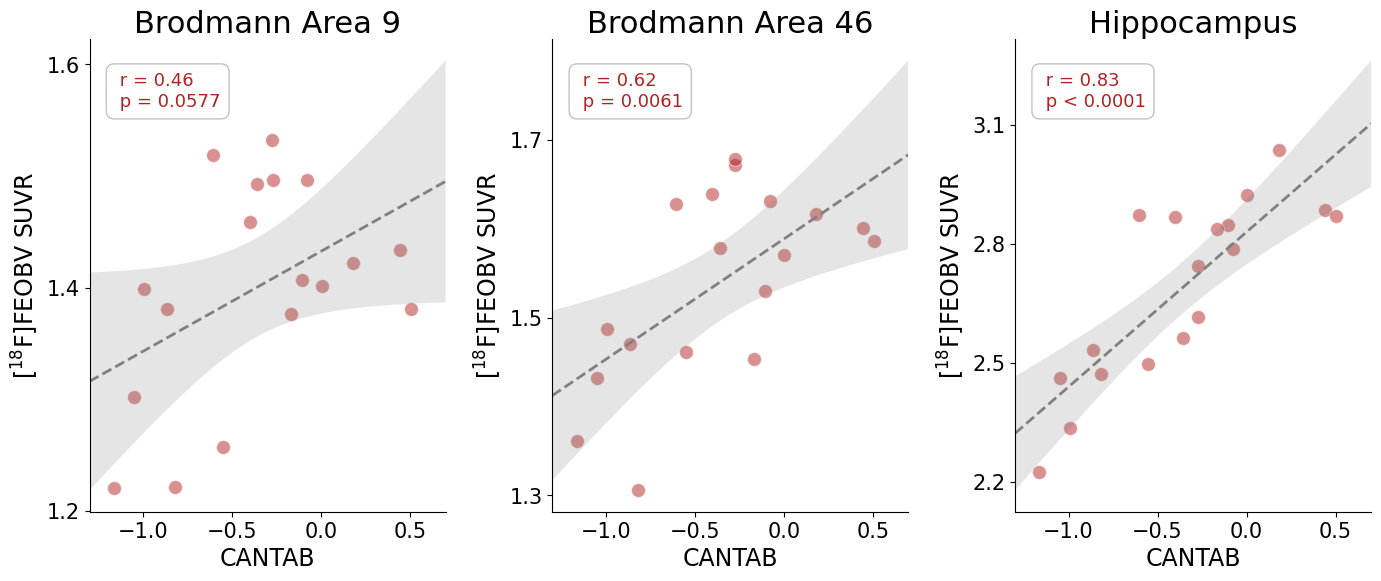

In [ ]:
######## plot CANTAB by BA9 / BA46 / HIP SUVRs

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd


# Define ROI info
ROI_info = {
	'BA9': {'label': 'Brodmann Area 9', 'ROI_ticks': [1.2, 1.4, 1.6]},
	'BA46': {'label': 'Brodmann Area 46', 'ROI_ticks': [1.3, 1.5, 1.7]},
	'HIP': {'label': 'Hippocampus', 'ROI_ticks': [2.2, 2.5, 2.8, 3.1]},
}

# Variables
X_var = 'CANTAB_composite_score'
X_label = 'CANTAB'
xticks = [-1, -0.5, 0, 0.5]

# Colors
patient_color = '#B22222'

# Load data
masterfile = pd.read_csv('data/masterfile_final_18patients_and_33controls.csv')
patients_only = masterfile[masterfile['Group'] == 'Schizophrenia'].copy()

# Create figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

for ax, ROI in zip(axes, ['BA9', 'BA46', 'HIP']):
	subset = patients_only[[ROI, X_var]].dropna()
	
	# Fit linear model using statsmodels
	X = subset[X_var]
	y = subset[ROI]
	X_const = sm.add_constant(X)
	model = sm.OLS(y, X_const).fit()

	# Prediction range (EXTENDED)
	x_pred = np.linspace(-1.3, 0.7, 200)
	x_pred_const = sm.add_constant(x_pred)
	y_pred = model.predict(x_pred_const)

	# Confidence intervals (95%)
	pred_summary = model.get_prediction(x_pred_const).summary_frame(alpha=0.05)
	lower = pred_summary['mean_ci_lower']
	upper = pred_summary['mean_ci_upper']

	# Scatter
	sns.scatterplot(
		data=subset,
		x=X_var,
		y=ROI,
		color=patient_color,
		alpha=0.5,
		s=100,
		ax=ax
	)

	# Regression line
	ax.plot(x_pred, y_pred, color='grey', linestyle='--', linewidth=2)

	# Shaded confidence interval
	ax.fill_between(x_pred, lower, upper, color='grey', alpha=0.2, edgecolor='none')

	ax.set_title(f'{ROI_info[ROI]["label"]}', fontsize=22, pad=2)
	ax.set_ylabel(r'[$^{18}$F]FEOBV SUVR', fontsize=17)
	ax.set_yticks(ROI_info[ROI]['ROI_ticks'])
	ax.set_xlabel(X_label, fontsize=17)
	ax.set_xticks(xticks)
	ax.set_xlim([-1.3, 0.7])
	ax.tick_params(axis='both', labelsize=15)
	sns.despine(ax=ax)

	# Correlation text
	r_val, p_val = stats.pearsonr(X, y)
	
	# Format p-value string
	if p_val < 0.0001:
		p_str = "p < 0.0001"
	else:
		p_str = f"p = {p_val:.4f}"
	
	ax.text(
		0.07, 0.93, f' r = {r_val:.2f}\n {p_str}',
		transform=ax.transAxes,
		fontsize=13,
		color=patient_color,
		verticalalignment='top',
		horizontalalignment='left',
		bbox=dict(boxstyle='round,pad=0.45', edgecolor='darkgrey', facecolor='white', alpha=0.7)
	)


# Save and show
plt.tight_layout(pad=5.0)
plt.subplots_adjust(wspace=0.3)

plt.savefig(f'plots/patients_only__{X_var}_BA9-46_and_HIP_correlations.jpg', dpi=700, bbox_inches='tight')
plt.show()


